#Labwork 8

In [1]:
import numpy as np
from numba import cuda, jit, prange
import cv2
from time import time
import matplotlib.pyplot as plt

In [2]:
# Load image
img = plt.imread('/content/wolf.jpg')
img2 = plt.imread('/content/wolf2.jpg')

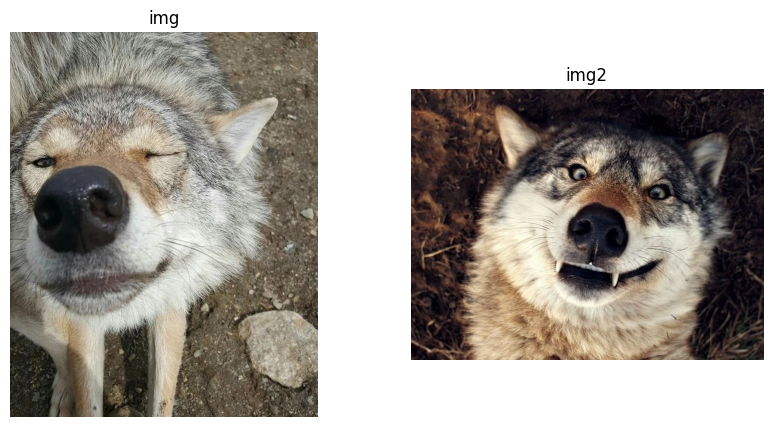

In [3]:
# Display the original image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('img2')
plt.axis('off')

plt.show()

##Conversion kernel

In [9]:
@cuda.jit
def rgb2hsv_kernel(rgb_image, H, S, V):
    height, width, _ = rgb_image.shape
    x, y = cuda.grid(2)

    if x < height and y < width:
        # Scale R, G, B to [0..1]
        r = rgb_image[x, y, 0] / 255.0
        g = rgb_image[x, y, 1] / 255.0
        b = rgb_image[x, y, 2] / 255.0

        rgb_max = max(r, g, b)
        rgb_min = min(r, g, b)
        delta = rgb_max - rgb_min

        # Value
        V[x, y] = rgb_max

        # Saturation
        if rgb_max == 0:
            S[x, y] = 0
        else:
            S[x, y] = delta / rgb_max

        # Hue
        if delta == 0:
            H[x, y] = 0
        elif rgb_max == r:
            H[x, y] = (60 * ((g - b) / delta) + 360) % 360
        elif rgb_max == g:
            H[x, y] = (60 * ((b - r) / delta) + 120) % 360
        elif rgb_max == b:
            H[x, y] = (60 * ((r - g) / delta) + 240) % 360

In [5]:
@cuda.jit
def hsv2rgb_kernel(H, S, V, rgb_image):
    height, width = H.shape
    x, y = cuda.grid(2)

    if x < height and y < width:
        h = H[x, y]
        s = S[x, y]
        v = V[x, y]

        if s == 0:
            rgb_image[x, y, 0] = rgb_image[x, y, 1] = rgb_image[x, y, 2] = int(v * 255)
        else:
            d = h / 60
            hi = int(d) % 6
            f = d - hi
            l = v * (1 - s)
            m = v * (1 - f * s)
            n = v * (1 - (1 - f) * s)

            if hi == 0:
                rgb_image[x, y, 0] = int(v * 255)
                rgb_image[x, y, 1] = int(n * 255)
                rgb_image[x, y, 2] = int(l * 255)
            elif hi == 1:
                rgb_image[x, y, 0] = int(m * 255)
                rgb_image[x, y, 1] = int(v * 255)
                rgb_image[x, y, 2] = int(l * 255)
            elif hi == 2:
                rgb_image[x, y, 0] = int(l * 255)
                rgb_image[x, y, 1] = int(v * 255)
                rgb_image[x, y, 2] = int(n * 255)
            elif hi == 3:
                rgb_image[x, y, 0] = int(l * 255)
                rgb_image[x, y, 1] = int(m * 255)
                rgb_image[x, y, 2] = int(v * 255)
            elif hi == 4:
                rgb_image[x, y, 0] = int(n * 255)
                rgb_image[x, y, 1] = int(l * 255)
                rgb_image[x, y, 2] = int(v * 255)
            elif hi == 5:
                rgb_image[x, y, 0] = int(v * 255)
                rgb_image[x, y, 1] = int(l * 255)
                rgb_image[x, y, 2] = int(m * 255)


## Conversion

In [6]:
def rgb2hsv(rgb_image):
    height, width, _ = rgb_image.shape
    H = np.zeros((height, width), dtype=np.float32)
    S = np.zeros((height, width), dtype=np.float32)
    V = np.zeros((height, width), dtype=np.float32)

    # Allocate device arrays
    d_rgb_image = cuda.to_device(rgb_image)
    d_H = cuda.to_device(H)
    d_S = cuda.to_device(S)
    d_V = cuda.to_device(V)

    # Define the grid and block sizes
    threads_per_block = (16, 16)
    blocks_per_grid_x = (height + (threads_per_block[0] - 1)) // threads_per_block[0]
    blocks_per_grid_y = (width + (threads_per_block[1] - 1)) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Launch the kernel
    rgb2hsv_kernel[blocks_per_grid, threads_per_block](d_rgb_image, d_H, d_S, d_V)

    # Copy the results back to the host
    H = d_H.copy_to_host()
    S = d_S.copy_to_host()
    V = d_V.copy_to_host()

    return H, S, V

In [7]:
def hsv2rgb(H, S, V):
    height, width = H.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Allocate device arrays
    d_H = cuda.to_device(H)
    d_S = cuda.to_device(S)
    d_V = cuda.to_device(V)
    d_rgb_image = cuda.to_device(rgb_image)

    # Define the grid and block sizes
    threads_per_block = (16, 16)
    blocks_per_grid_x = (height + (threads_per_block[0] - 1)) // threads_per_block[0]
    blocks_per_grid_y = (width + (threads_per_block[1] - 1)) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Launch the kernel
    hsv2rgb_kernel[blocks_per_grid, threads_per_block](d_H, d_S, d_V, d_rgb_image)

    # Copy the results back to the host
    rgb_image = d_rgb_image.copy_to_host()

    return rgb_image

##Converting

In [10]:
# Convert RGB to HSV
H, S, V = rgb2hsv(img)

#Convert HSV to RGB
reconstructed_img = hsv2rgb(H, S, V)

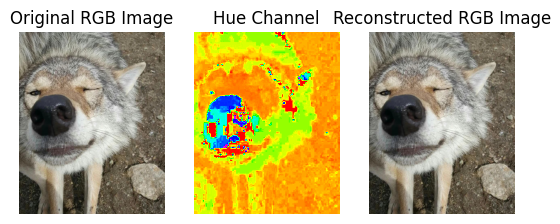

In [11]:
# Original RGB Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original RGB Image')
plt.axis('off')

# Hue Channel
plt.subplot(1, 3, 2)
plt.imshow(H / 360.0, cmap='hsv')  # Normalize H to [0, 1] for display
plt.title('Hue Channel')
plt.axis('off')

# Reconstructed RGB Image
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_img)
plt.title('Reconstructed RGB Image')
plt.axis('off')

plt.show()

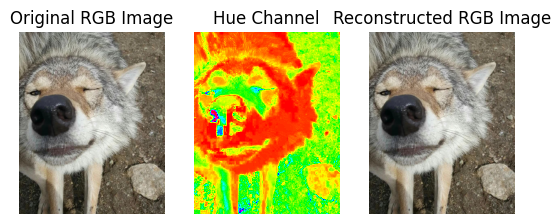

In [12]:
# Original RGB Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original RGB Image')
plt.axis('off')

# Satuation Channel
plt.subplot(1, 3, 2)
plt.imshow(S / 360.0, cmap='hsv')  # Normalize S to [0, 1] for display
plt.title('Hue Channel')
plt.axis('off')

# Reconstructed RGB Image
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_img)
plt.title('Reconstructed RGB Image')
plt.axis('off')

plt.show()

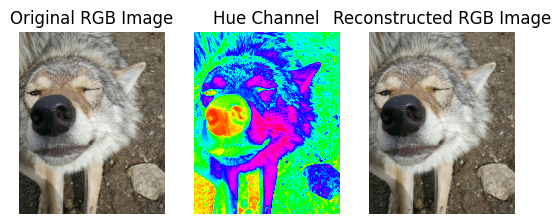

In [13]:
# Original RGB Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original RGB Image')
plt.axis('off')

# Value Channel
plt.subplot(1, 3, 2)
plt.imshow(V / 360.0, cmap='hsv')  # Normalize V to [0, 1] for display
plt.title('Hue Channel')
plt.axis('off')

# Reconstructed RGB Image
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_img)
plt.title('Reconstructed RGB Image')
plt.axis('off')

plt.show()